# Overview

This file creates the Pandas datasets out of the initial python scripts and saves them as files in the folder, with suffix "latest". These files are then used to create the data for econometric analysis.

# Setup

In [1]:
import gc
# Clear all variables to free up memory
for name in dir():
    if not name.startswith('_') and name not in ['gc']:
        del globals()[name]

gc.collect()
print("All variables cleared and garbage collected")
import pandas as pd
import os
import sys
import dask.dataframe as dd

os.chdir('/shared/share_scp/coresignal/gitrepo_facebook')

if '/shared/share_scp/coresignal/gitrepo_facebook' in sys.modules:
    for module_name in list(sys.modules.keys()):
        if module_name.startswith('university_name_matcher'):
            del sys.modules[module_name]

from university_name_matcher import university_name_matcher
umatcher = university_name_matcher()

os.chdir('/shared/share_scp/coresignal')

All variables cleared and garbage collected



# 1. Convert the raw files into an analysis file
These are the files created from Python CSVs into Pandas

### 1.1 Read the files on education experience

In [2]:
universities_adopted_facebook = umatcher.load_university_data() 
x = universities_adopted_facebook[universities_adopted_facebook['instnm'].duplicated()].instnm

print("Number of duplicate university IDs:", universities_adopted_facebook[universities_adopted_facebook['instnm'].isin(x)].shape[0])


print("Number of NA in name", universities_adopted_facebook['instnm'].isna().sum())

Loaded 6528 universities from the dataset
Kept 6300 unique universities after removing duplicates
Number of duplicate university IDs: 0
Number of NA in name 0


In [3]:
import glob
education_files = sorted(glob.glob('processed_data2/coresignal_member_education_*linkedin*.pkl'))
print(f'Found {len(education_files)} education files')
coresignal_member_education_all = pd.concat(
    [pd.read_pickle(f) for f in education_files],
    ignore_index=True
)

coresignal_member_education_all['member_id'] = coresignal_member_education_all['member_id'].astype(int)
coresignal_member_education_all = coresignal_member_education_all.drop_duplicates()
member_ids = coresignal_member_education_all['member_id'].astype(int).unique()
print(f"Number of unique member IDs: {len(member_ids)}")



Found 122 education files
Number of unique member IDs: 10916706


In [4]:
#Scratch
print("Checking for duplicates in the combined DataFrame")
dups0= coresignal_member_education_all.duplicated(['id']).sum()
total0 = coresignal_member_education_all.shape[0]
coresignal_member_education_all = coresignal_member_education_all[~coresignal_member_education_all.title.str.contains("university of phoenix|devry university", case=False, na=False)]
dups1 = coresignal_member_education_all.duplicated(['id']).sum()
total1 = coresignal_member_education_all.shape[0]

pct0 = dups0 / total0 * 100
pct1 = dups1 / total1 * 100
print(f"Total duplicates found: {dups0:,} ({pct0:.2f}%). Dropped to {dups1:,} ({pct1:.2f}%) after filtering for 'university of phoenix|devry university'")


Checking for duplicates in the combined DataFrame
Total duplicates found: 3,345,980 (12.51%). Dropped to 571,993 (2.41%) after filtering for 'university of phoenix|devry university'


In [5]:

import numpy as np
from Levenshtein import distance as levenshtein_distance

# Function to safely calculate Levenshtein distance
def safe_levenshtein(str1, str2):
    if pd.isna(str1) or pd.isna(str2):
        return np.nan
    return levenshtein_distance(str(str1).lower(), str(str2).lower())

# Calculate Levenshtein distance using .loc to avoid SettingWithCopyWarning
coresignal_member_education_all.loc[:, 'levenshtein_distance'] = coresignal_member_education_all.apply(
    lambda row: safe_levenshtein(row['title'], row['instnm']), 
    axis=1
)

# Display the results
print("Levenshtein distances between title and university name:")


Levenshtein distances between title and university name:


In [6]:
coresignal_member_education_all.loc[:, 'is_duplicated'] = coresignal_member_education_all.duplicated(['id'])

pd.concat([coresignal_member_education_all[coresignal_member_education_all['is_duplicated']].sample(10),
              coresignal_member_education_all[~coresignal_member_education_all['is_duplicated']].sample(10)],
              ignore_index=True)[['id', 'member_id', 'title', 'instnm', 'levenshtein_distance', 'is_duplicated']]



,id,member_id,title,instnm,levenshtein_distance,is_duplicated
0,998524874,53729265,the art institutes,The Art Institute of Portland,12.0,True
1,1652978591,326036849,art institute of atlanta,The Illinois Institute of Art-Chicago,20.0,True
2,919954621,427201359,universal technical institute of texas inc,Universal Technical Institute of Illinois Inc,7.0,True
3,1615377232,386733375,wilmington university,Wilmington College,9.0,True
4,933703934,133277096,the art institutes,The Art Institute of Portland,12.0,True
5,930943797,287051614,art institute of dallas,The Art Institute of Atlanta,9.0,True
6,904164891,297124174,miami international university of art and design,The Art Institute of Atlanta,33.0,True
7,1151951442,240153414,the art institutes,The Art Institute of Philadelphia,16.0,True
8,978490167,355886835,art institute of colorado,The Art Institute of Las Vegas,13.0,True
9,1497054161,521341002,the art institutes,The Art Institute of Washington,13.0,True


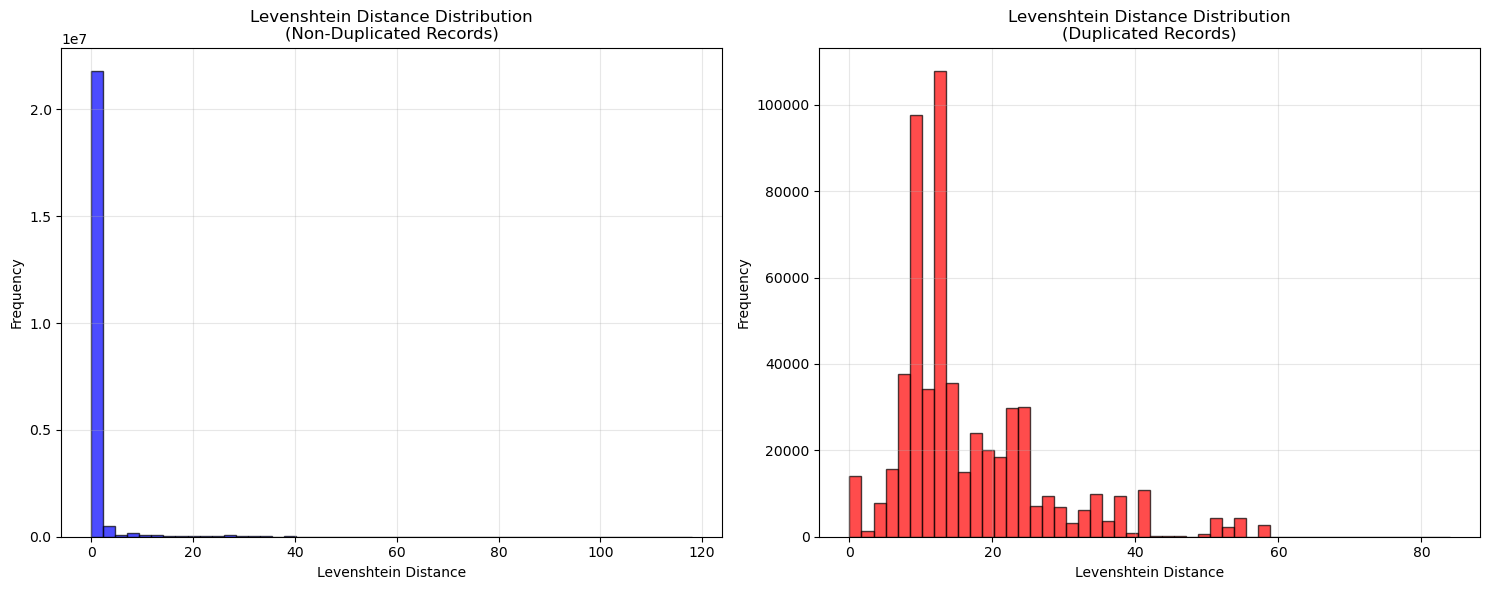

Non-duplicated records - Mean distance: 0.83, Median: 0.00
Duplicated records - Mean distance: 16.58, Median: 13.00
Non-duplicated count: 23,139,960
Duplicated count: 571,821


In [7]:
import matplotlib.pyplot as plt

# Create subplots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for non-duplicated records
non_duplicated_distances = coresignal_member_education_all[~coresignal_member_education_all['is_duplicated']]['levenshtein_distance'].dropna()
ax1.hist(non_duplicated_distances, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_title('Levenshtein Distance Distribution\n(Non-Duplicated Records)')
ax1.set_xlabel('Levenshtein Distance')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Plot histogram for duplicated records
duplicated_distances = coresignal_member_education_all[coresignal_member_education_all['is_duplicated']]['levenshtein_distance'].dropna()
ax2.hist(duplicated_distances, bins=50, alpha=0.7, color='red', edgecolor='black')
ax2.set_title('Levenshtein Distance Distribution\n(Duplicated Records)')
ax2.set_xlabel('Levenshtein Distance')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Non-duplicated records - Mean distance: {non_duplicated_distances.mean():.2f}, Median: {non_duplicated_distances.median():.2f}")
print(f"Duplicated records - Mean distance: {duplicated_distances.mean():.2f}, Median: {duplicated_distances.median():.2f}")
print(f"Non-duplicated count: {len(non_duplicated_distances):,}")
print(f"Duplicated count: {len(duplicated_distances):,}")

In [8]:
coresignal_member_education_all = coresignal_member_education_all[~coresignal_member_education_all['is_duplicated']]

In [9]:
total_rows = coresignal_member_education_all.shape[0]
coresignal_member_education_all = coresignal_member_education_all[~coresignal_member_education_all['school_url'].str.endswith('linkedin.com/edu/school')]
print(f"Total rows before filtering: {total_rows:,}")
print(f"Total rows after filtering:  {coresignal_member_education_all.shape[0]:,}")

Total rows before filtering: 23,140,711
Total rows after filtering:  23,140,711


In [10]:
coresignal_member_education_all['subtitle'].value_counts().head(20) 
coresignal_member_education_all = coresignal_member_education_all[~coresignal_member_education_all['subtitle'].isna()]


In [ ]:
# Create masks for filtering educational levels: only bachelors and masters
mask0 = (coresignal_member_education_all['subtitle'].str.contains(r'Bachelor\'?s?|Undergrad|\sB\.?A\.?|B\.?S\.?', na=False) | 
    coresignal_member_education_all['subtitle'].str.contains(r'Master\'?s|MS|M\.S|MBA|M\.B\.A', na=False)) 

# Exclude associate degrees
mask1 = mask0 & (~coresignal_member_education_all['subtitle'].str.contains(r'Associate', na=False))
    


# Exclide medical and doctoral degrees
mask = mask1 & (~coresignal_member_education_all['subtitle'].str.contains(r'Ph\.?D\.?|Doctor|MD|M\.D\.', na=False))
mask = mask & (~coresignal_member_education_all['subtitle'].str.contains(r'Nursing|Medical', na=False))

# Exclude lawyers
mask = mask & (~coresignal_member_education_all['subtitle'].str.contains(r'Law|J\.?D\.?', na=False))

# Exclude technicians -- just in case
mask = mask & (~coresignal_member_education_all['subtitle'].str.contains(r'Technician', na=False))





In [ ]:
# Filter for bachelor's degrees or undergrad
coresignal_member_education = coresignal_member_education_all[mask]
print(f"Filtered from {len(coresignal_member_education_all):,} to {len(coresignal_member_education):,} records for bachelor's or masters degrees.")


print(f"Deleting coresignal_member_education_all object")

del coresignal_member_education_all
gc.collect()

Filtered from 21,992,742 to 10,575,945 records for bachelor's or undergrad degrees.
Deleting coresignal_member_education_all object


142

### 1.2 Read the files on employment experience

In [13]:
import glob
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import time

def read_pickle_file(filepath):
    return pd.read_pickle(filepath)

# Find all processed pickle files matching the pattern
os.chdir('/shared/share_scp/coresignal') #make sure it is in the right directory

processed_files = sorted(glob.glob('processed_data/coresignal_member_experience_*START*.pkl'))
print(f'Found {len(processed_files):,} files with experience.')

# Use parallel processing with manual progress tracking
max_workers = min(len(processed_files), multiprocessing.cpu_count())
print(f'Using {max_workers} workers for parallel processing.')

dataframes = []
start_time = time.time()

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_file = {executor.submit(read_pickle_file, file): file 
                     for file in processed_files}
    
    # Process completed tasks and show progress
    for i, future in enumerate(as_completed(future_to_file), 1):
        dataframes.append(future.result())
        
        # Print progress every 10 files or at the end
        if i % 10 == 0 or i == len(processed_files):
            elapsed = time.time() - start_time
            rate = i / elapsed if elapsed > 0 else 0
            remaining = len(processed_files) - i
            eta = remaining / rate if rate > 0 else 0
            
            print(f"Progress: {i:,}/{len(processed_files):,} files ({i/len(processed_files)*100:.1f}%) | "
                  f"Rate: {rate:.1f} files/sec | "
                  f"Time Left: {eta:.0f}s | "
                  f"Elapsed: {elapsed:.0f}s")

print("Concatenating dataframes...")
all_experience = pd.concat(dataframes, ignore_index=True)

print(f"Total rows in all experience data: {len(all_experience):,}")


Found 272 files with experience.
Using 128 workers for parallel processing.
Progress: 10/272 files (3.7%) | Rate: 0.1 files/sec | Time Left: 2184s | Elapsed: 83s
Progress: 20/272 files (7.4%) | Rate: 0.2 files/sec | Time Left: 1082s | Elapsed: 86s
Progress: 30/272 files (11.0%) | Rate: 0.3 files/sec | Time Left: 724s | Elapsed: 90s
Progress: 40/272 files (14.7%) | Rate: 0.4 files/sec | Time Left: 537s | Elapsed: 93s
Progress: 50/272 files (18.4%) | Rate: 0.5 files/sec | Time Left: 422s | Elapsed: 95s
Progress: 60/272 files (22.1%) | Rate: 0.6 files/sec | Time Left: 353s | Elapsed: 100s
Progress: 70/272 files (25.7%) | Rate: 0.7 files/sec | Time Left: 295s | Elapsed: 102s
Progress: 80/272 files (29.4%) | Rate: 0.8 files/sec | Time Left: 248s | Elapsed: 103s
Progress: 90/272 files (33.1%) | Rate: 0.9 files/sec | Time Left: 214s | Elapsed: 106s
Progress: 100/272 files (36.8%) | Rate: 0.9 files/sec | Time Left: 184s | Elapsed: 107s
Progress: 110/272 files (40.4%) | Rate: 1.0 files/sec | Ti

In [ ]:
# limit to those with education records that will be our focus
all_experience = all_experience[all_experience['member_id'].isin(coresignal_member_education['member_id'])]
print(f"Total rows in all experience data after filtering to undergrad and grad: {len(all_experience):,}")

Total rows in all experience data after filtering to undergrad graduates: 88,684,308


In [15]:

import time

start_time = time.time()
print(f"Total rows in all experience data: {len(all_experience):,}")
print("Removing duplicates...")
key_columns = ['member_id','location','company_url','duration','order_in_profile','company_id', 'company_name', 'title', 'date_from', 'date_to']
all_experience = all_experience.drop_duplicates(subset=['id'])
print(f"Total rows in all experience data (after removing duplicates): {len(all_experience):,}")
elapsed_time = time.time() - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"Time taken to remove duplicates: {minutes}m {seconds}s")


Total rows in all experience data: 88,684,308
Removing duplicates...
Total rows in all experience data (after removing duplicates): 88,684,308
Time taken to remove duplicates: 1m 36s


### 1.3 Testing and validations

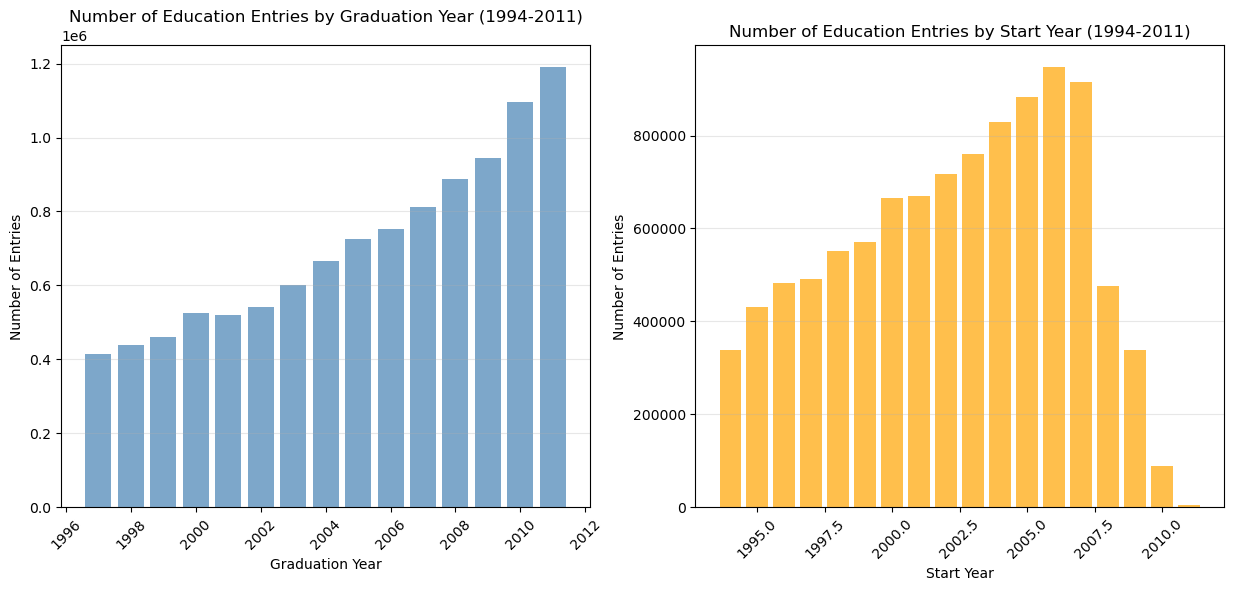

In [16]:
# Plot the number of entries by graduation year


# Create subplots for graduation year and start year
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot graduation year
grad_year_counts = coresignal_member_education.loc[(coresignal_member_education['year_to'] >= 1994) & (coresignal_member_education['year_to'] <= 2011),'year_to'].value_counts().sort_index()
ax1.bar(grad_year_counts.index, grad_year_counts.values, alpha=0.7, color='steelblue')
ax1.set_title('Number of Education Entries by Graduation Year (1994-2011)')
ax1.set_xlabel('Graduation Year')
ax1.set_ylabel('Number of Entries')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Plot start year
start_year_counts = coresignal_member_education.loc[(coresignal_member_education['year_from'] >= 1994) & (coresignal_member_education['year_from'] <= 2011),'year_from'].value_counts().sort_index()
ax2.bar(start_year_counts.index, start_year_counts.values, alpha=0.7, color='orange')
ax2.set_title('Number of Education Entries by Start Year (1994-2011)')
ax2.set_xlabel('Start Year')
ax2.set_ylabel('Number of Entries')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)


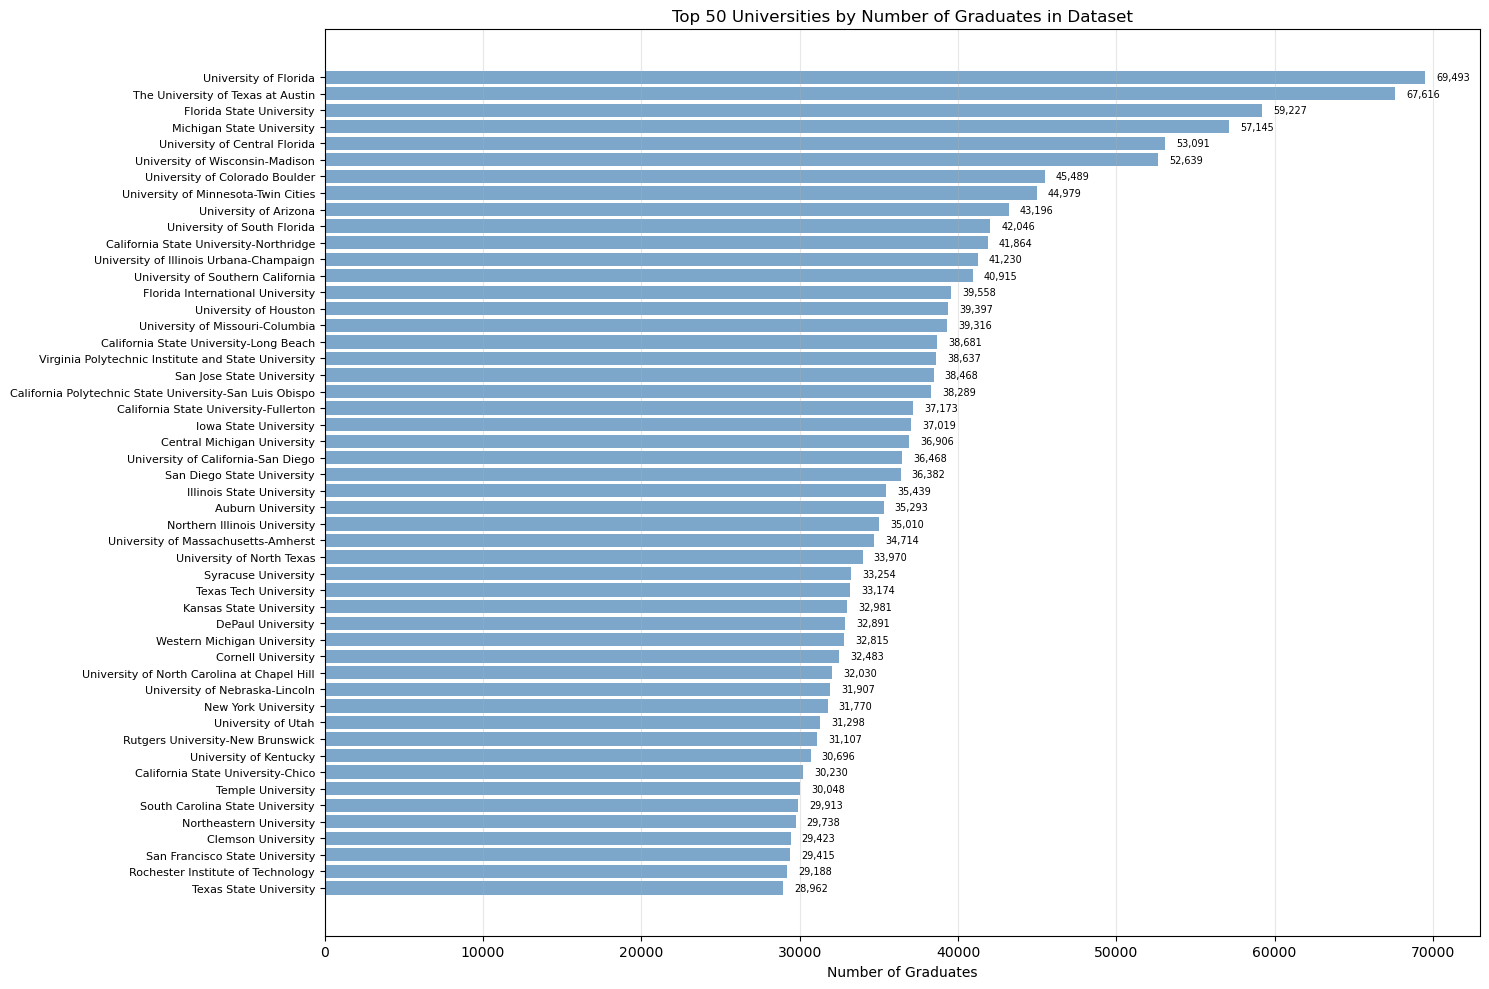

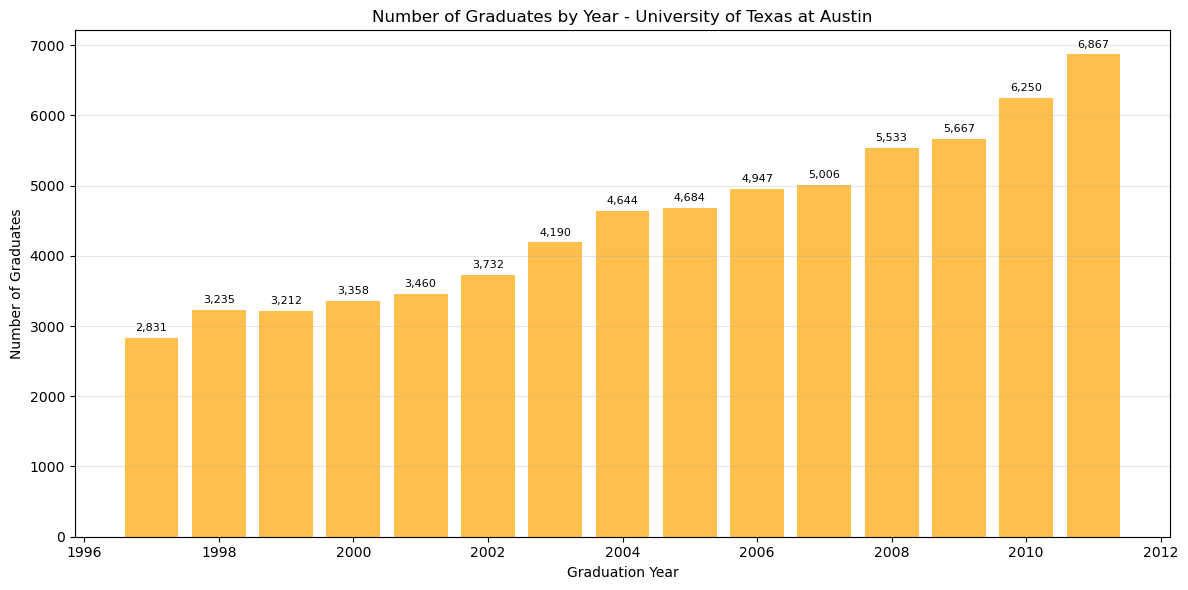

Total UT Austin graduates in dataset: 67,616
Year range: 1997 - 2011


In [17]:
# Get top 50 universities by number of graduates
top_50_universities = coresignal_member_education['instnm'].value_counts().head(50)

# Create the plot
plt.figure(figsize=(15, 10))
bars = plt.barh(range(len(top_50_universities)), top_50_universities.values, color='steelblue', alpha=0.7)

# Customize the plot
plt.yticks(range(len(top_50_universities)), top_50_universities.index, fontsize=8)
plt.xlabel('Number of Graduates')
plt.title('Top 50 Universities by Number of Graduates in Dataset')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_50_universities.values)):
    plt.text(value + max(top_50_universities.values) * 0.01, i, f'{value:,}', 
             va='center', fontsize=7)

# Invert y-axis so highest counts are at top
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Filter data for University of Texas at Austin
ut_austin_data = coresignal_member_education[
    coresignal_member_education['instnm'] == 'The University of Texas at Austin'
]

# Get graduation year counts for UT Austin
ut_austin_grad_years = ut_austin_data['year_to'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(ut_austin_grad_years.index, ut_austin_grad_years.values, color='orange', alpha=0.7)
plt.title('Number of Graduates by Year - University of Texas at Austin')
plt.xlabel('Graduation Year')
plt.ylabel('Number of Graduates')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for year, count in ut_austin_grad_years.items():
    plt.text(year, count + max(ut_austin_grad_years.values) * 0.01, 
             f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Total UT Austin graduates in dataset: {len(ut_austin_data):,}")
print(f"Year range: {ut_austin_grad_years.index.min()} - {ut_austin_grad_years.index.max()}")


### 1.4 Output and save the analysis files

In [ ]:
coresignal_member_education.to_pickle('/shared/share_scp/coresignal/coresignal_member_education_AnalysisFile_latest.pkl')


In [19]:

all_experience.to_pickle('/shared/share_scp/coresignal/all_experience_AnalysisFile_latest.pkl')


,id,member_id,title,subtitle,date_from,date_to,activities_and_societies,description,school_url,year_from,year_to,keep,unitid,instnm,levenshtein_distance,is_duplicated
3,330884274,379358538,bradley university,"B.S., Industrial Engineering",2002,2007,<p>Activities and Societies: President of Sigm...,<p>Minor in Business Administration</p>,https://www.linkedin.com/edu/bradley-universit...,2002,2007,True,143358,Bradley University,0.0,False
7,431334499,379358965,boston college,"Bachelor’s Degree, Communication, General, GPA...",2007,2011,<p>Activities and Societies: Magna Cum Laude. ...,"<p>Courses included Advertising and Marketing,...",https://us.linkedin.com/edu/boston-college-18457,2007,2011,True,164924,Boston College,0.0,False
10,331635750,379359416,arkansas state university,"Bachelor of Science, Computer Science",2002,2007,<p>Activities and Societies: Treasurer 2006 As...,<p>Minor: Management Information Systems</p>,https://www.linkedin.com/edu/arkansas-state-un...,2002,2007,True,106458,Arkansas State University,0.0,False
11,478793658,379359426,chadron state college,"Bachelor of Business Administration (BBA), Man...",1993,1998,NaN,NaN,https://www.linkedin.com/edu/chadron-state-col...,1993,1998,True,180948,Chadron State College,0.0,False
15,333758492,379359534,seton hall university,"Bachelor's, Diplomacy and International Relations",2004,2008,NaN,<p>Activities and Societies: Chamber and Touri...,https://www.linkedin.com/edu/seton-hall-univer...,2004,2008,True,186584,Seton Hall University,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26739938,2021397000,2150122,full sail university,"Bachelor of Science (BS), Entertainment Business",2009,2010,NaN,Constructed a new business concept (a concert ...,https://www.linkedin.com/school/full-sail-univ...,2009,2010,True,134237,Full Sail University,0.0,False
26739941,1752366928,2150172,state university of new york at stony brook,"MS, Geosciences (Low Temperature Aqueous Geoch...",2002,2004,Activities and Societies: Advisor to the Under...,NaN,https://www.linkedin.com/school/stony-brook-un...,2002,2004,True,196097,Stony Brook University,34.0,False
26739943,1838563648,2150172,suny new paltz,"BS/BA, Physics/Geology, 3.20",1996,2002,"Activities and Societies: Physics Club, Campus...",NaN,https://bg.linkedin.com/school/sunynewpaltz,1996,2002,True,196176,State University of New York at New Paltz,27.0,False
26739945,1771232766,2150195,vanguard university of southern california,"BS, Sociology (Minor in English)",2002,2006,NaN,NaN,https://tn.linkedin.com/school/vanguard-univer...,2002,2006,True,123651,Vanguard University of Southern California,0.0,False
